In [ ]:
import pandas as pd
from dateutil import relativedelta, parser
from pandas.tseries.offsets import BDay
from datetime import datetime, date, time
import numpy as np
import pickle
import time
import re
import matplotlib.pyplot as plt
import pandas_datareader.data as reader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/2019.QTR1.pkl")
df2 = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/2019.QTR2.pkl")
df = pd.concat([df, df2], ignore_index=True, sort=False)
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df["texts"] = ""

In [ ]:
# get the content between first item and signatures

#define the pattern
pattern1 = r"Item \d{1,2}\.\d{2}[\s\S]*SIGNATURE"

#define the function
def get_content(row):
    newtext = re.search(pattern1, row, flags=re.I)
    if newtext:
        return newtext.group().rstrip("SIGNATURE")
    else:
        return None

# apply the function
df["texts"] = df.string.apply(get_content)

In [ ]:
df.isnull().sum()

symbol             0
cik                0
form               0
access_number      0
filed_date         0
accepted_date      0
report_url         0
filing_url         0
string             0
texts            335
items              0
dtype: int64

In [ ]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [ ]:
# get document lengths
df["lens"] = df.texts.apply(lambda x: len(x.split()))

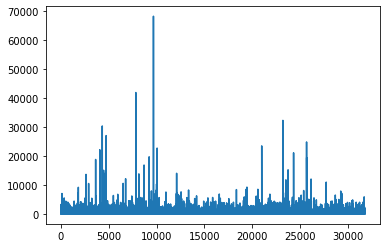

In [ ]:
plt.plot(df.lens)
plt.show()

In [ ]:
df = df[df.lens < df.lens.quantile(.90)]

In [ ]:
df = df.reset_index(drop=True).copy()

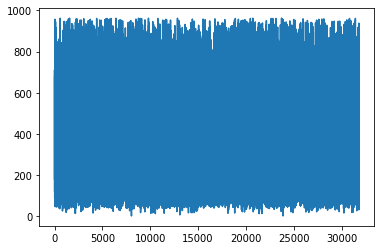

In [ ]:
plt.plot(df.lens)
plt.show()

In [ ]:
np.max(df["lens"])

962

In [ ]:
# get unique symbol list for market data query
symbol_list = list(df.symbol.unique())
np.savetxt('symbols.txt',symbol_list,fmt='%s')

In [ ]:
# load market data
df_wrds = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/262dl80hiicwin8b.csv")
df_wrds.head()

,PERMNO,DATE,n,RET,b_mkt,alpha,ivol,tvol,R2,exret,TICKER
0,10026,2019/02/20,252,-0.1147%,0.4087,0.0005,1.4233%,1.4875%,8.4436%,-0.2024%,JJSF
1,10026,2019/01/17,252,1.3348%,0.4774,-0.0000,1.2455%,1.3557%,15.5948%,0.9611%,JJSF
2,10026,2019/07/18,252,0.9715%,0.3061,0.0002,1.3836%,1.4171%,4.6774%,0.8553%,JJSF
3,10026,2019/01/15,252,-1.1510%,0.4860,0.0002,1.2564%,1.3696%,15.8559%,-1.6814%,JJSF
4,10026,2019/04/26,252,1.1806%,0.3405,0.0003,1.4358%,1.4733%,5.0328%,0.9912%,JJSF


In [ ]:
df = df[df["symbol"].isin(df_wrds["TICKER"])]

In [ ]:
# define function to process return columns
def to_float(x):
  try:
    x = float(x.strip('%'))/100
  except:
    x = np.nan
  return x

In [ ]:
df_wrds["RET"] = df_wrds["RET"].apply(to_float)
df_wrds["exret"] = df_wrds["exret"].apply(to_float)

In [ ]:
# define function to take one-day percentage change
def get_pct1(row):
    h = int(row["accepted_date"].split()[1].split(":")[0])
    
    tckr = row["symbol"]

    if h>=16:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")

        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          pct_change = temp[temp["DATE"] == end_date_str]["RET"].values[0]
        except:
           pct_change = np.nan    
    
    else:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")
        end_date = start_date
        end_date_str = end_date.strftime ("%Y/%m/%d")
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          pct_change = temp[temp["DATE"] == end_date_str]["RET"].values[0]
        except:
          pct_change = np.nan

    return pct_change

In [ ]:
# define function to get 2-day percentage change
def get_pct2(row):
    h = int(row["accepted_date"].split()[1].split(":")[0])
    
    tckr = row["symbol"]

    if h>=16:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")

        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          pct_change = temp[temp["DATE"] == end_date_str]["RET"].values[0]
        except:
           pct_change = np.nan    
    
    else:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")
        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          pct_change1 = temp[temp["DATE"] == start_date_str]["RET"].values[0]
          pct_change2 = temp[temp["DATE"] == end_date_str]["RET"].values[0]
          pct_change = (1+pct_change1)*(1+pct_change2)-1
        except:
          pct_change = np.nan

    return pct_change

In [ ]:
# apply the functions
df["pct_change1"] = df.apply(get_pct1, axis=1)
df["pct_change2"] = df.apply(get_pct2, axis=1)

In [ ]:
# define function to get one-day stock beta
def get_beta1(row):
    h = int(row["accepted_date"].split()[1].split(":")[0])
    
    tckr = row["symbol"]

    if h>=16:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")

        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          beta = temp[temp["DATE"] == end_date_str]["b_mkt"].values[0]
        except:
           beta = np.nan    
    
    else:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")
        end_date = start_date
        end_date_str = end_date.strftime ("%Y/%m/%d")
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          beta = temp[temp["DATE"] == end_date_str]["b_mkt"].values[0]

        except:
          beta = np.nan

    return beta

In [ ]:
# define funtion to get 2-day arithmetic mean stock beta
def get_beta2(row):
    h = int(row["accepted_date"].split()[1].split(":")[0])
    
    tckr = row["symbol"]

    if h>=16:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")

        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          beta = temp[temp["DATE"] == end_date_str]["b_mkt"].values[0]
        except:
           beta = np.nan    
    
    else:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")
        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          beta1 = temp[temp["DATE"] == end_date_str]["b_mkt"].values[0]
          beta2 = temp[temp["DATE"] == start_date_str]["b_mkt"].values[0]
          beta = (beta1 + beta2)/2

        except:
          beta = np.nan

    return beta

In [ ]:
# apply the functions
df["beta1"] = df.apply(get_beta1, axis=1)
df["beta2"] = df.apply(get_beta2, axis=1)

In [ ]:
# define the function to get one-day market return
def get_mkt_ret1(row):
    h = int(row["accepted_date"].split()[1].split(":")[0])
    
    tckr = row["symbol"]

    if h>=16:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")

        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          exret = temp[temp["DATE"] == end_date_str]["exret"].values[0]
        except:
           exret = np.nan    
    
    else:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")
        end_date = start_date
        end_date_str = end_date.strftime ("%Y/%m/%d")
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          exret = temp[temp["DATE"] == start_date_str]["exret"].values[0]
          #exret2 = temp[temp["DATE"] == end_date_str]["exret"].values[0]
          #exret = (1+exret1)*(1+exret2)-1

        except:
          exret = np.nan

    return exret

In [ ]:
# define the function to get 2-day market return
def get_mkt_ret2(row):
    h = int(row["accepted_date"].split()[1].split(":")[0])
    
    tckr = row["symbol"]

    if h>=16:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")

        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          exret = temp[temp["DATE"] == end_date_str]["exret"].values[0]
        except:
           exret = np.nan    
    
    else:
        start_date =datetime.strptime(row["accepted_date"].split()[0], "%Y-%m-%d")
        start_date_str = start_date.strftime ("%Y/%m/%d")
        end_date = start_date + BDay(1)
        end_date_str = end_date.strftime ("%Y/%m/%d")
        temp = df_wrds[df_wrds["TICKER"] == tckr]
        try:
          exret1 = temp[temp["DATE"] == start_date_str]["exret"].values[0]
          exret2 = temp[temp["DATE"] == end_date_str]["exret"].values[0]
          exret = (1+exret1)*(1+exret2)-1

        except:
          exret = np.nan

    return exret

In [ ]:
# apply the functions
df["mkt_excess1"] = df.apply(get_mkt_ret1, axis=1)
df["mkt_excess2"] = df.apply(get_mkt_ret2, axis=1)

In [ ]:
df.isnull().sum()

symbol              0
cik                 0
form                0
access_number       0
filed_date          0
accepted_date       0
report_url          0
filing_url          0
string              0
texts               0
lens                0
pct_change1      1534
pct_change2      1833
beta1            1532
beta2            1831
mkt_excess1      1542
mkt_excess2      1841
dtype: int64

In [ ]:
# save to pickle
df.to_pickle("/content/drive/MyDrive/Colab Notebooks/wholething.pkl")

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/wholething.pkl")

In [ ]:
# define function to get industry of the registrant
def get_industry(row):
  
    tckr = row["symbol"]

    try:
      industry = ft[ft["TICKER"] == tckr]["NAICS"].values[0]
    except:
      industry = np.nan
  
    return industry

In [ ]:
df["ind"] = df.apply(get_industry, axis = 1)

In [ ]:
df.to_pickle("/content/drive/MyDrive/Colab Notebooks/wholething_ind.pkl")